In [1]:
# Import the general functions for metabolic modelling
%run 'general_functions.ipynb'

fs = 16 # fontsize for figures
growth_norm = True

Using license file /home/users/hherrmann/gurobi.lic
Academic license - for non-commercial use only


In [2]:
# Load the four model instances: OxR resistant and sensitive, and
# RuR resistant and sensitive 
model_wt = cobra.io.read_sbml_model("../Models/Colon_Combined_exo_woBile_WT.xml")
model_oxr = cobra.io.read_sbml_model("../Models/Colon_Combined_exo_woBile_OxR.xml")
model_dmso = cobra.io.read_sbml_model("../Models/Colon_Combined_exo_woBile_WT+DMSO.xml")
model_rur = cobra.io.read_sbml_model("../Models/Colon_Combined_exo_woBile_RuR+DMSO.xml")

models = [model_wt,model_oxr,model_dmso,model_rur]

conditions = ["WT","OxR","WT-DMSO","RuR"]
cols = ["blue","red","black","orange"]

In [3]:
# Reactions of interest
fatty_acid_rxns = [r.id for r in model_wt.reactions if "FAx" in r.id]
o2 = "HMR_9048"
bm = "HCC_biomass"

In [4]:
# For parimonious flux variability analysis
def add_flux_constraint(rxns,constraint,ret=False):
    coefficients = dict()
    for rxn in rxns:
        coefficients[rxn.forward_variable] = 1.
        coefficients[rxn.reverse_variable] = 1.
    all_rxn_constraint = model.problem.Constraint(0, lb=constraint-1, ub=constraint+1)
    model.add_cons_vars(all_rxn_constraint)
    model.solver.update()
    all_rxn_constraint.set_linear_coefficients(coefficients=coefficients)
    if ret:
        return(all_rxn_constraint) #pfba_solution.objective_value

In [5]:
# Parameters of the calculated production evnelope 
fa_fluxes = np.arange(0,50,1)
bm_fluxes = np.arange(5,15,1)

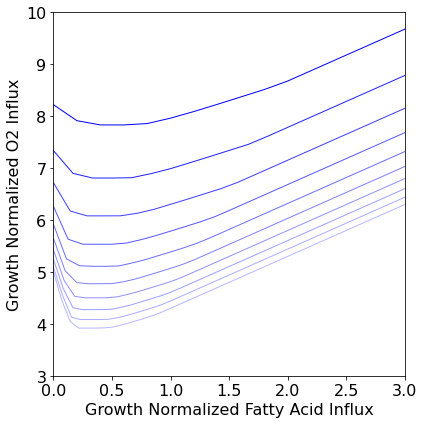

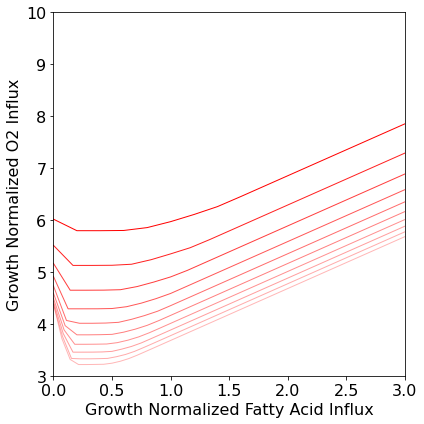

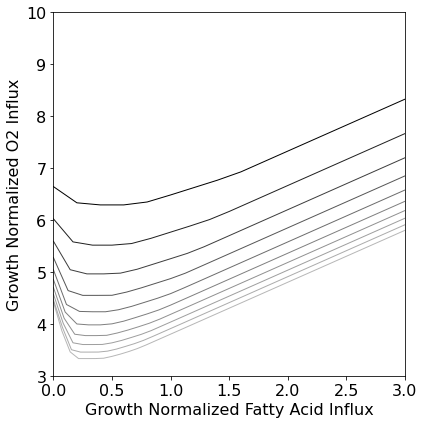

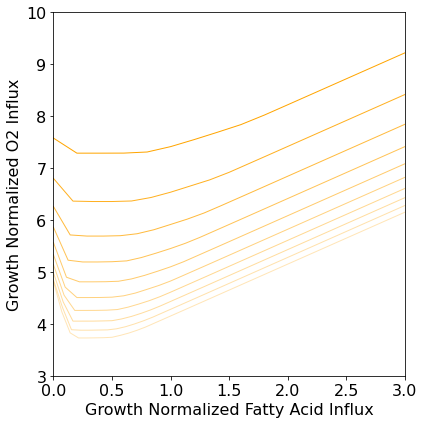

In [6]:
# plot production envelope of O2 against fatty acids uptake 

for model,condition,col in zip(models,conditions,cols):
    plt.figure(figsize=(6,6))
    adj = 1
    for bm_constraint in bm_fluxes:
        bm_rxns = model.reactions.get_by_id(bm)
        bm_rxns.lower_bound = bm_constraint
        bm_rxns.upper_bound = bm_constraint
        pfba_sols = []
        bm_sols = []
        FA_rxns = [model.reactions.get_by_id(rid) for rid in fatty_acid_rxns]
        FA_fluxes = dict()
        for constraint in fa_fluxes:
            try:
                # Apply overall constraint to all fatty acid import reactions
                FA_constraint = add_flux_constraint(FA_rxns,constraint,ret=True)
                o2_pfba = flux_variability_analysis(model,o2)['minimum'] #cobra.flux_analysis.pfba(model,reactions=[o2])
                bm_pfba = flux_variability_analysis(model,bm)['minimum'] #cobra.flux_analysis.pfba(model,reactions=[bm])
                FA_pfba = cobra.flux_analysis.pfba(model,reactions=fatty_acid_rxns)
                if growth_norm:
                    pfba_sols.append(o2_pfba[o2]/bm_pfba[bm])
                    FA_fluxes[constraint] = [FA_pfba[FA]/bm_pfba[bm] for FA in fatty_acid_rxns]
                else: 
                    pfba_sols.append(o2_pfba[o2])
                    FA_fluxes[constraint] = [FA_pfba[FA] for FA in fatty_acid_rxns]
                bm_sols.append(bm_pfba[bm])
            except:
                pfba_sols.append(np.nan)
                bm_sols.append(np.nan)
                FA_fluxes[constraint] = [0]*len(fatty_acid_rxns)
            model.remove_cons_vars(FA_constraint)
            model.solver.update()
        if growth_norm:
            fa_fluxes_plot = [f/b for f,b in zip(fa_fluxes,bm_sols)]
        else:
            fa_fluxes_plot = fa_fluxes.copy()
        plt.plot(fa_fluxes_plot,pfba_sols,color=col,label=None,alpha=adj,linewidth=1)
        adj = adj/1.15

    plt.xlabel("Growth Normalized Fatty Acid Influx",fontsize=fs)
    plt.ylabel("Growth Normalized O2 Influx",fontsize=fs)
    plt.yticks(fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.ylim(3,10)
    plt.xlim(0,3)
    plt.tight_layout()
    plt.savefig("../Figures/Hypoxia/FAvsO2vsGrowth_{}_woBile.svg".format(condition))
    plt.show()
    plt.close()